In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report
import shutil
from glob import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(42)
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.metrics import confusion_matrix
import splitfolders

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
skin_df = pd.read_csv('dataverse_files/HAM10000_metadata')

In [7]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x 
              for x in glob(os.path.join('dataverse_files/', '*', '*.jpg'))}

In [8]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [9]:
print(skin_df['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


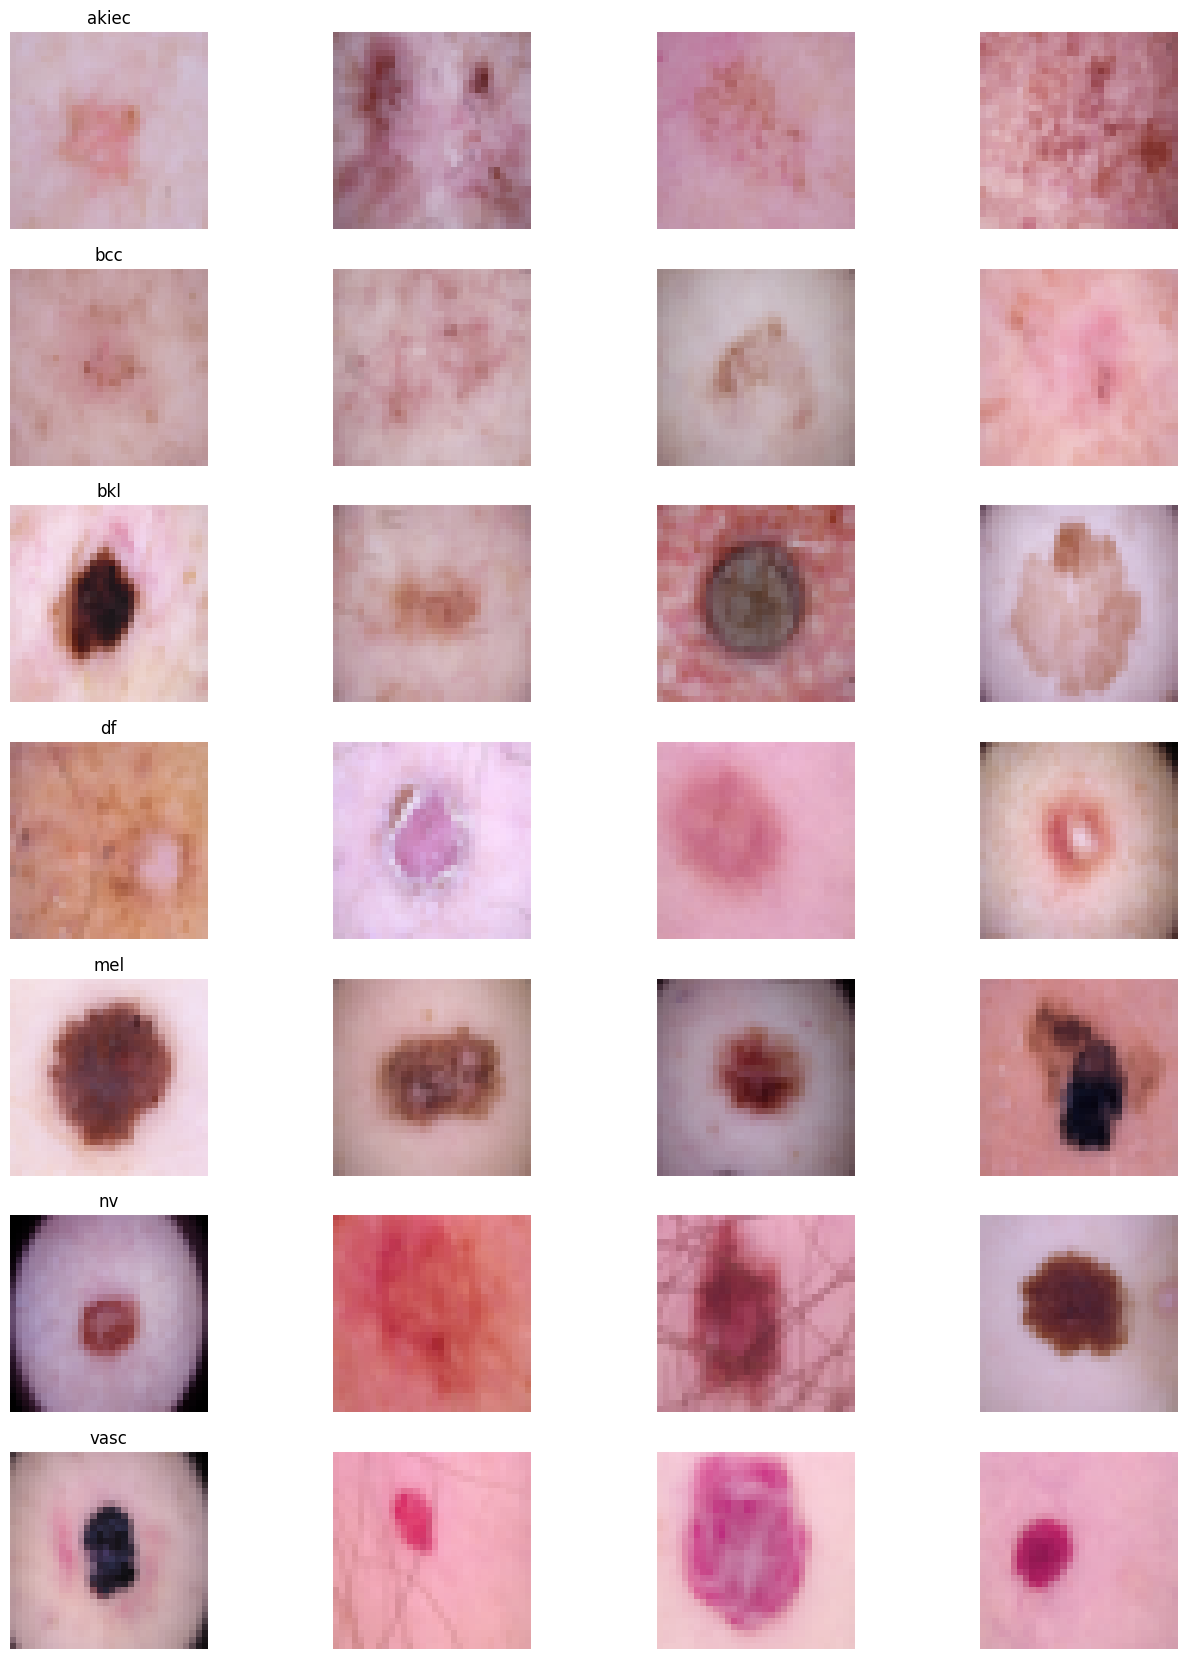

In [10]:
n_samples = 4
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [11]:
# Dump all images into a folder and specify the path:
data_dir = os.getcwd() + "\\data\\all_images\\"

# Path to destination directory where we want subfolders
dest_dir = os.getcwd() + "\\data\\reorganized\\"

In [12]:
skin_df2 = pd.read_csv('dataverse_files/HAM10000_metadata')
print(skin_df['dx'].value_counts())

label= skin_df2['dx'].unique().tolist()
label_images = []

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [14]:
# Copy images to new folders
for i in label:
    os.makedirs(dest_dir + str(i) + "\\")
    sample = skin_df2[skin_df2['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        shutil.copyfile((data_dir + id +".jpg"), (dest_dir + i + "\\"+id+".jpg"))
    label_images=[]

In [15]:
#To define any transformations we want to apply to images
datagen = ImageDataGenerator()
train_dir = os.getcwd() + "\\data\\reorganized\\"
train_data_keras = datagen.flow_from_directory(directory= train_dir, class_mode='categorical',
                                               batch_size= 128,  #16 images at a time
                                               target_size=(32,32))  #Resize images

Found 10015 images belonging to 7 classes.


In [17]:
SIZE= 32

In [18]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [19]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(5))

        lesion_id      image_id   dx    dx_type   age     sex localization  \
851   HAM_0004004  ISIC_0029872  bkl  consensus  65.0  female        chest   
4868  HAM_0004057  ISIC_0026635   nv  follow_up  65.0    male        trunk   
1819  HAM_0004302  ISIC_0033029  mel      histo  60.0    male      abdomen   
8191  HAM_0000182  ISIC_0026270   nv      histo  60.0    male         neck   
9349  HAM_0003027  ISIC_0025355   nv  consensus  35.0  female         back   

            dataset                                               path  \
851    vidir_modern  dataverse_files\HAM10000_images_part_2\ISIC_00...   
4868  vidir_molemax  dataverse_files\HAM10000_images_part_1\ISIC_00...   
1819   vidir_modern  dataverse_files\HAM10000_images_part_2\ISIC_00...   
8191    vienna_dias  dataverse_files\HAM10000_images_part_1\ISIC_00...   
9349   vidir_modern  dataverse_files\HAM10000_images_part_1\ISIC_00...   

                                                  image  label  
851   [[[187, 164, 18

C:\Users\asus\AppData\Local\Temp\ipykernel_19156\1848369455.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


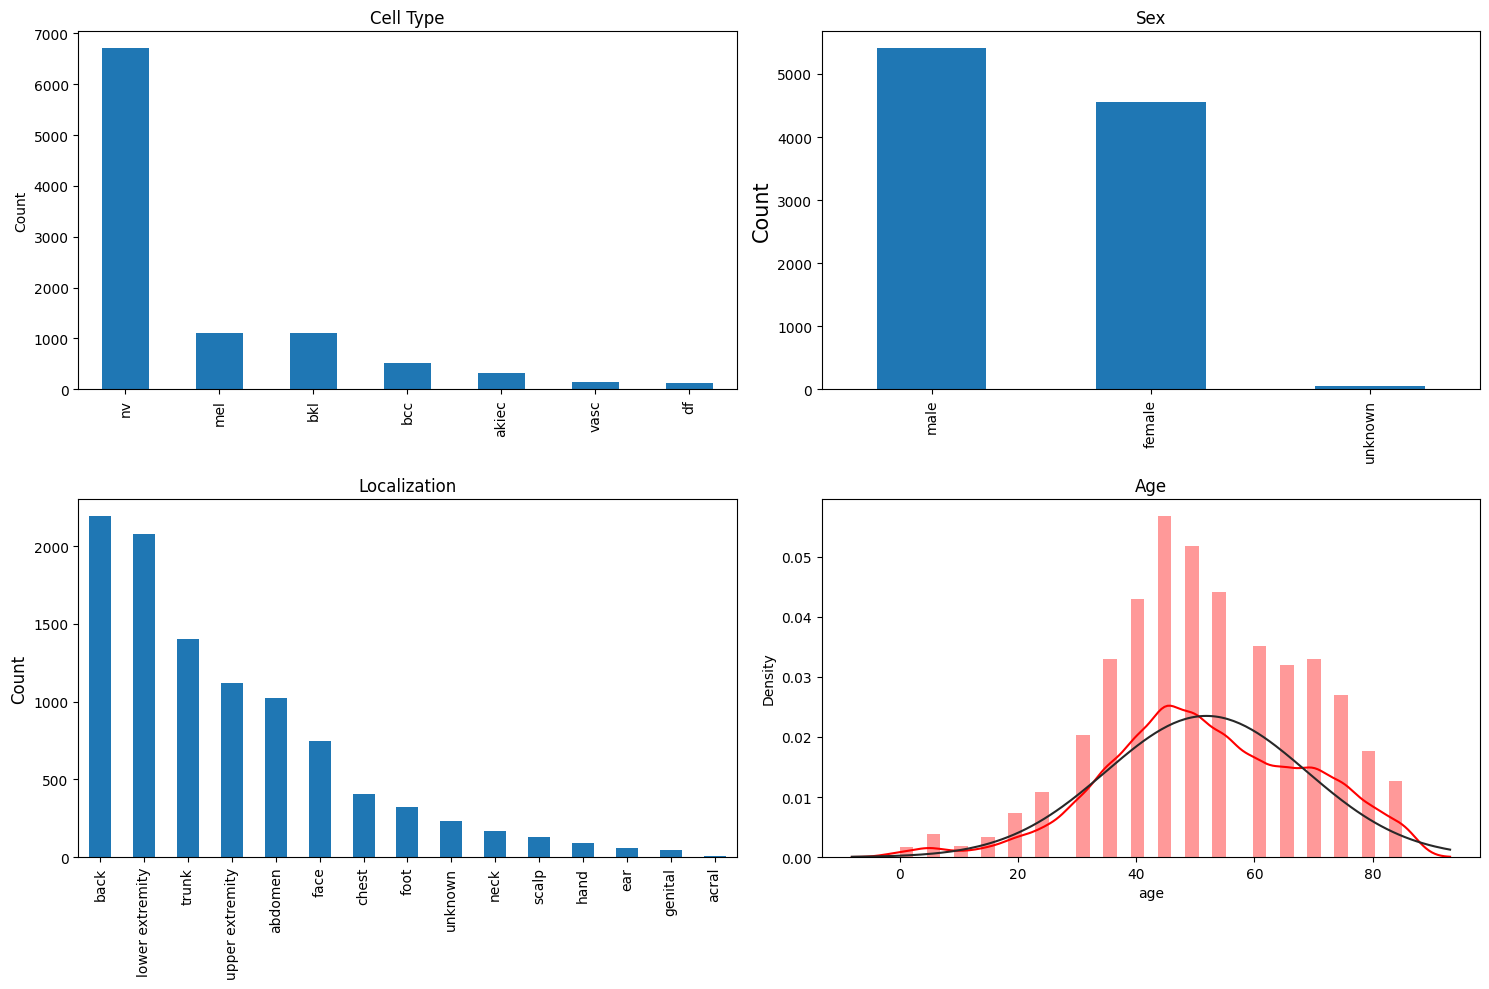

In [20]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.utils import resample
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 

df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [22]:
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [23]:
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [24]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x 
              for x in glob(os.path.join('dataverse_files/', '*', '*.jpg'))}

In [25]:
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [26]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. 
Y=skin_df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

In [27]:
import gc
gc.collect()

31998

In [28]:
x_unused, x_valid, y_unused, y_valid = train_test_split(x_test_auto, y_test_auto, test_size=0.05, random_state=42)

### AutoKeras

In [29]:
clf = ak.ImageClassifier(max_trials=25)
clf.fit(x_train_auto, y_train_auto, epochs=10)

INFO:tensorflow:Reloading Oracle from existing project .\image_classifier\oracle.json
INFO:tensorflow:Reloading Tuner from .\image_classifier\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
6/6 [==============================] - 11s 47ms/step - loss: 2.7140 - accuracy: 0.1600
Epoch 2/10
6/6 [==============================] - 0s 18ms/step - loss: 1.7353 - accuracy: 0.3657
Epoch 3/10
6/6 [==============================] - 0s 17ms/step - loss: 1.1792 - accuracy: 0.5714
Epoch 4/10
6/6 [==============================] - 0s 17ms/step - loss: 1.0178 - accuracy: 0.6286
Epoch 5/10
6/6 [==============================] - 0s 17ms/step - loss: 0.7712 - accuracy: 0.7657
Epoch 6/10
6/6 [==============================] - 0s 17ms/step - loss: 0.5842 - accuracy: 0.8743
Epoch 7/10
6/6 [==============================] - 0s 17ms/step - loss: 0.4271 - accuracy: 0.9257
Epoch 8/10
6/6 [==============================] - 0s 17ms/step - loss: 0.3211 - accuracy: 0.9486
Epoch 9/10
6/6 [===============

INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


INFO:tensorflow:Assets written to: .\image_classifier\best_model\assets


In [30]:
_, acc = clf.evaluate(x_valid, y_valid)
print("Accuracy = ", (acc * 100.0), "%")

6/6 [==============================] - 1s 54ms/step - loss: 2.3743 - accuracy: 0.4431
Accuracy =  44.3113774061203 %


In [31]:
# get the final best performing model
model = clf.export_model()
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 512)       14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 512)      0         
 )                                                               
                                                             

In [32]:
score = model.evaluate(x_valid, y_valid)
print('Test accuracy:', score[1])

6/6 [==============================] - 0s 53ms/step - loss: 2.3743 - accuracy: 0.4431
Test accuracy: 0.443113774061203


In [33]:
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. 
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [35]:
#Define the model.

num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 128)         0

In [36]:
batch_size = 16 
epochs = 30

In [37]:
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/30
165/165 - 4s - loss: 1.8566 - acc: 0.2130 - val_loss: 1.8360 - val_acc: 0.2160 - 4s/epoch - 23ms/step
Epoch 2/30
165/165 - 2s - loss: 1.7159 - acc: 0.3002 - val_loss: 1.5898 - val_acc: 0.3566 - 2s/epoch - 12ms/step
Epoch 3/30
165/165 - 2s - loss: 1.5292 - acc: 0.3768 - val_loss: 1.4573 - val_acc: 0.4034 - 2s/epoch - 12ms/step
Epoch 4/30
165/165 - 2s - loss: 1.4651 - acc: 0.4103 - val_loss: 1.4060 - val_acc: 0.4149 - 2s/epoch - 12ms/step
Epoch 5/30
165/165 - 2s - loss: 1.4331 - acc: 0.4248 - val_loss: 1.3768 - val_acc: 0.4446 - 2s/epoch - 12ms/step
Epoch 6/30
165/165 - 2s - loss: 1.3715 - acc: 0.4530 - val_loss: 1.3793 - val_acc: 0.4411 - 2s/epoch - 12ms/step
Epoch 7/30
165/165 - 2s - loss: 1.3966 - acc: 0.4381 - val_loss: 1.4467 - val_acc: 0.3657 - 2s/epoch - 12ms/step
Epoch 8/30
165/165 - 2s - loss: 1.3186 - acc: 0.4766 - val_loss: 1.3109 - val_acc: 0.4663 - 2s/epoch - 12ms/step
Epoch 9/30
165/165 - 2s - loss: 1.2937 - acc: 0.4838 - val_loss: 1.2784 - val_acc: 0.4800 - 2s/e

In [38]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

28/28 [==============================] - 0s 6ms/step - loss: 1.0405 - acc: 0.6286
Test accuracy: 0.6285714507102966


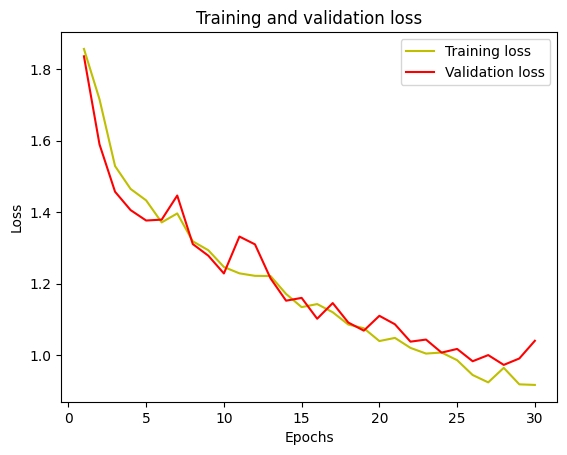

In [39]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

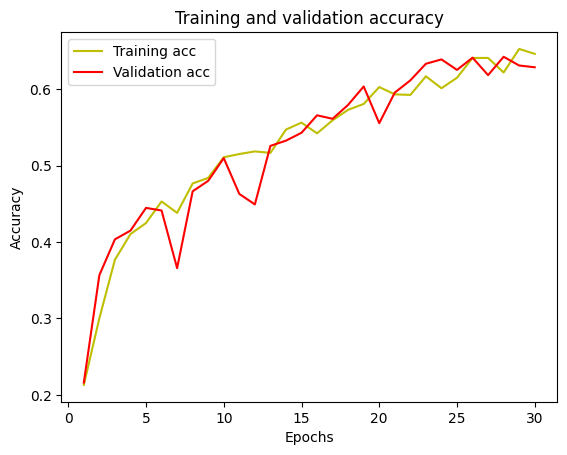

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# Prediction on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

28/28 [==============================] - 3s 17ms/step


<AxesSubplot: >

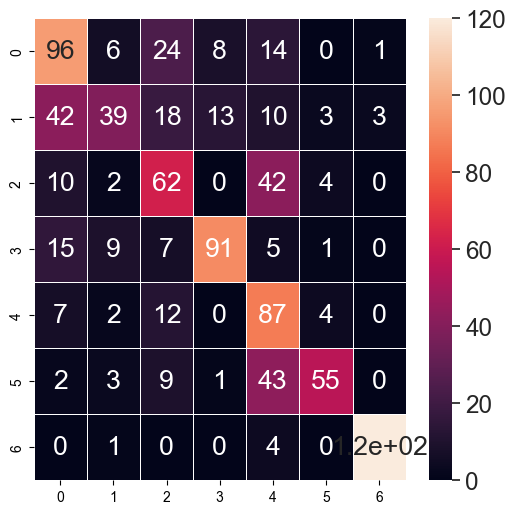

In [42]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)